In [1]:
# load functions for data analysis
from adapting_fyp_analysis import experimental, visualizeStats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy
import numpy as np
from scipy import stats

In [2]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data_path = '/Users/biota/Desktop/sSL/experiment_2/collection/scr_data/'

In [4]:
day1 = experimental(data_path)
day1.day = 1
day1.preprocessData()

In [5]:
day2 = experimental(data_path)
day2.day = 2
day2.preprocessData()

In [88]:
cb = []; cb_name = []
bc = []; bc_name = []

for i_subject in range(0,len(day2.subjectNames)): 
    
    subject_number = int(day2.subjectNames[i_subject][1:3])
    
    condMarkers = np.copy(day2.transData[i_subject][1])
    pos_ons = day2.stimuli(condMarkers[:,1])[0]
    neg_ons = day2.stimuli(condMarkers[:,0])[0]
    
    if pos_ons[0] > neg_ons[0]: 
        cb.append(i_subject)
        cb_name.append(subject_number)
    else: 
        bc.append(i_subject)
        bc_name.append(subject_number)
        
cb = np.array(cb)
bc = np.array(bc)

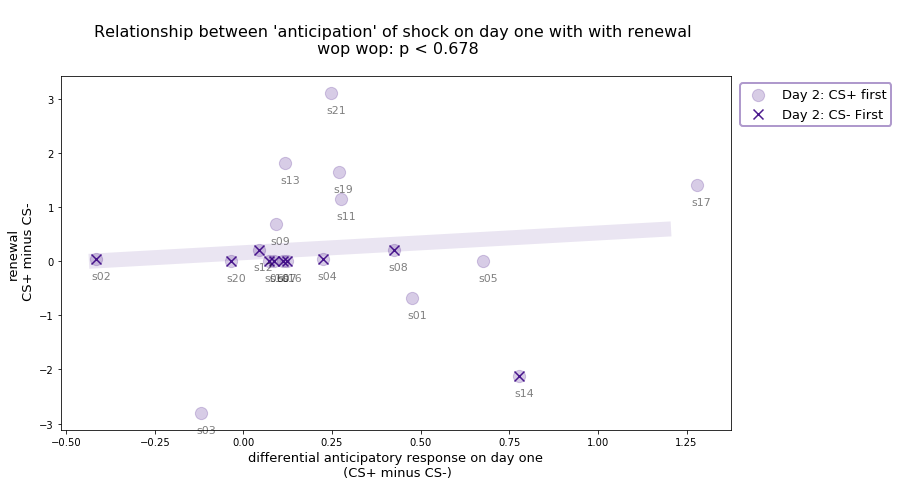

In [111]:
conditioning_start = 4
conditioning_end  = 13
conditioning = list(range(conditioning_start, conditioning_end))

CSP = np.zeros([day1.nSubjects,len(conditioning)])
CSM = np.zeros([day1.nSubjects,len(conditioning)])

day1.nSeconds = 5
for iStim in range(0,len(conditioning)):
    CSP[:,iStim], CSM[:,iStim] = day1.amplitudeDifference('trans', conditioning[iStim], 'onset');


# figure this error out
# iStim = 15
# last_plus, last_minus = day1.amplitudeDifference('trans',iStim, 'onset');
# last_CS = last_plus - last_minus

iStim = 0
###### FFFFFFUUUUUUCCCCCKKKKKKK these are switched in the biopac  :) 
day2_minus, day2_plus = day2.amplitudeDifference('trans', iStim, 'onset');

x_axis = mean(CSP - CSM,1)
y_axis =  (day2_plus - day2_minus)# - last_CS

slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)

figure(figsize=[12, 6.5])

# plot data 
scatter(x_axis, y_axis, color='xkcd:indigo',alpha=.2, s=150, label='Day 2: CS+ first')
scatter(x_axis[cb], y_axis[cb], marker='x', color='xkcd:indigo',alpha=.9, s=100, label='Day 2: CS- First')

# plot line fit to data
x_line = np.arange(min(x_axis), max(x_axis), .1)
y_line = slope * x_line + intercept 
plot(x_line, y_line, alpha=.1, linewidth=15, color='xkcd:indigo')

# control aesthetics
lgnd = legend(fontsize=13, fancybox=True, frameon=True, bbox_to_anchor=(.25, 1, 1, 0))
lgnd.get_frame().set_edgecolor('xkcd:indigo')
lgnd.get_frame().set_linewidth(2)
lgnd.get_frame().set_alpha(.4)
xlabel('differential anticipatory response on day one\n (CS+ minus CS-)',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title("\nRelationship between 'anticipation' of shock on day one with with renewal \n wop wop: p < %.3f\n"% p_value,fontsize=16); 

for i_subject in range(day1.nSubjects): 
    plt.annotate(day1.subjectNames[i_subject][0:3], xy=(x_axis[i_subject], y_axis[i_subject]), 
                                 xytext=(-5, -20), textcoords='offset points', alpha=.5, fontsize=11)

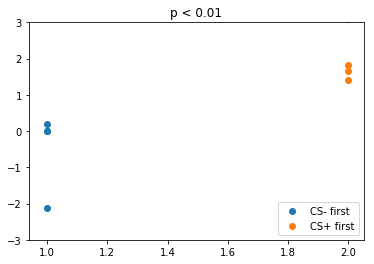

In [103]:
_, p = stats.ttest_ind(y_axis[bc][5:], y_axis[cb][6:])

not_cb = np.nonzero([int(day2.subjectNames[ii][1:3]) not in cb for ii in range(len(cb))])[0]

plt.scatter(np.ones(len(cb[6:])), y_axis[cb][6:], label='CS- first')
plt.scatter(np.ones(len(bc[5:]))+1, y_axis[bc][5:],label='CS+ first')
plt.ylim([-3,3])
plt.legend(loc=4)
plt.title('p < %s'%round(p,3)); 

0.010065087018244594

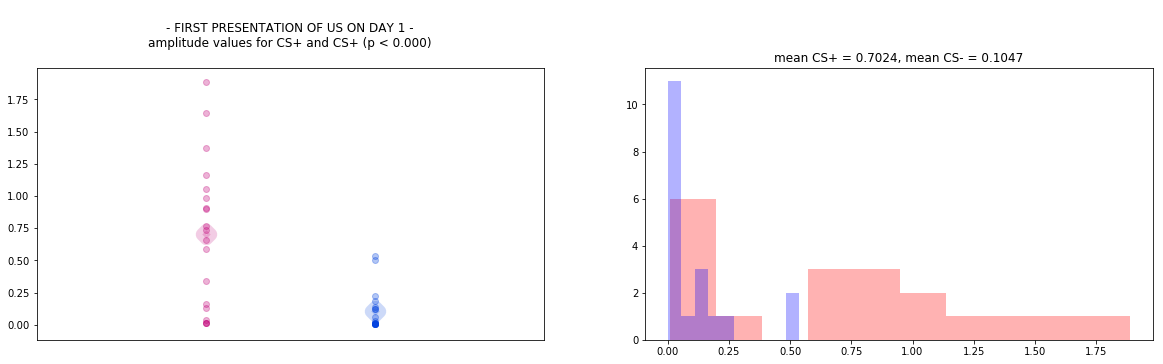

In [9]:
iStim = 3
day1.nSeconds = 4
plus, minus = day1.amplitudeDifference('raw',iStim,'offset');
results = scipy.stats.wilcoxon(plus,minus);
visualizeStats(plus,minus,results, 
               heading='FIRST PRESENTATION OF US ON DAY 1')

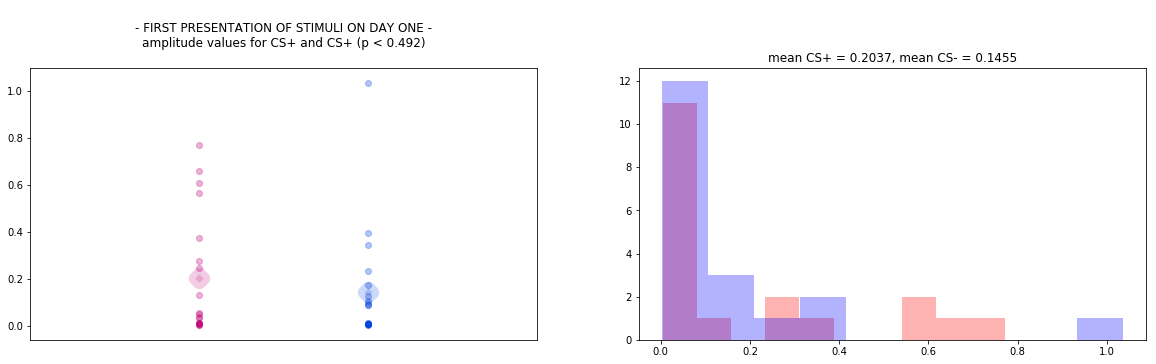

In [10]:
iStim = 0
day1.nSeconds = 4
plus, minus = day1.amplitudeDifference('raw', iStim, 'onset');

results = scipy.stats.wilcoxon(plus,minus);
visualizeStats(plus,minus,results, 
               heading='FIRST PRESENTATION OF STIMULI ON DAY ONE')

In [11]:
iStim = 0
day2.nSeconds = 4
minus, plus = day2.amplitudeDifference('trans',iStim,'onset');

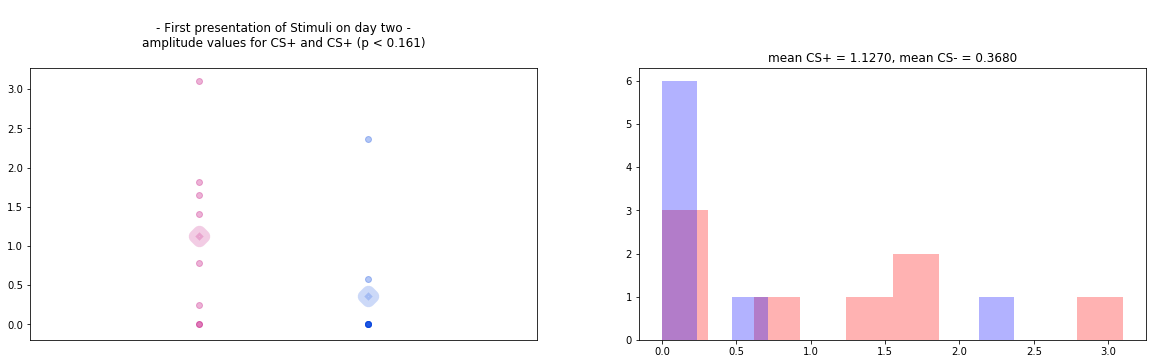

In [12]:
results = scipy.stats.wilcoxon(plus[11:], minus[11:]);
visualizeStats(plus[11:], minus[11:], results, heading='First presentation of Stimuli on day two')

In [35]:
len(plus[11:])

8

In [144]:
x_axis = mean(CSP - CSM,1)
y_axis =  (plus - minus) #- last_CS
#y_abs =   abs(y_axis)[11:] # y_abs[abs(x_axis) > .1]
#x_axis = x_axis[11:]       #[abs(x_axis) > .1]
x_axis = x_axis[11:]
y_axis = y_axis[11:]

In [145]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis,y_axis)

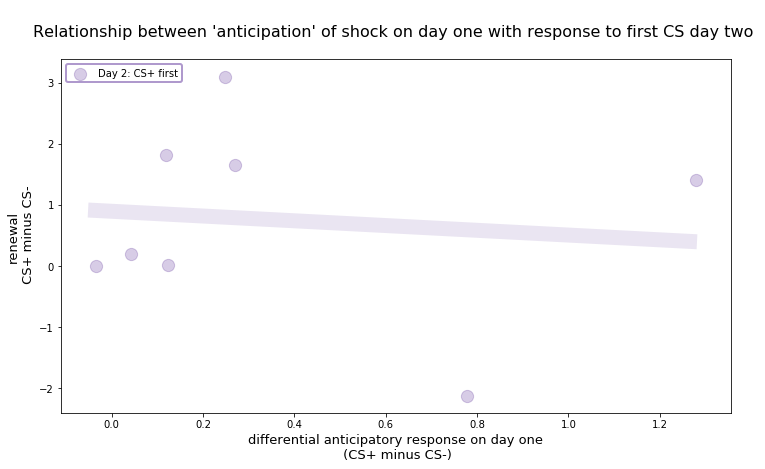

In [146]:
figure(figsize=[12, 6.5])

scatter(x_axis, y_axis, color='xkcd:indigo',alpha=.2, s=150, label='Day 2: CS+ first')
#scatter(x_axis[cb], y_abs[cb], marker='x', color='xkcd:indigo',alpha=.9, s=100, label='Day 2: CS- First')

x = np.arange(min(x_axis), max(x_axis), .1)
y = slope*x + intercept 
plot(x, y, alpha=.1, linewidth=15, color='xkcd:indigo')

lgnd = legend(fontsize=10, fancybox=True, frameon=True, loc=2) #bbox_to_anchor=(.2, 1, 1, 0))
lgnd.get_frame().set_edgecolor('xkcd:indigo')
lgnd.get_frame().set_linewidth(2)
lgnd.get_frame().set_alpha(.4)
xlabel('differential anticipatory response on day one\n (CS+ minus CS-)',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title("\nRelationship between 'anticipation' of shock on day one with response to first CS day two \n", fontsize=16); 

In [54]:
# figure(figsize=[12, 6.5])

# scatter(x_axis[11:], y_abs[11:], color='xkcd:indigo',alpha=.2, s=150, label='Day 2: CS+ first')
# #scatter(x_axis[cb], y_abs[cb], marker='x', color='xkcd:indigo',alpha=.9, s=100, label='Day 2: CS- First')

# x = np.arange(min(x_axis[11:]), max(x_axis[11:]), .1)
# y = slope*x + intercept 
# plot(x, y, alpha=.1, linewidth=15, color='xkcd:indigo')

# lgnd = legend(fontsize=10, fancybox=True, frameon=True, loc=2) #bbox_to_anchor=(.2, 1, 1, 0))
# lgnd.get_frame().set_edgecolor('xkcd:indigo')
# lgnd.get_frame().set_linewidth(2)
# lgnd.get_frame().set_alpha(.4)
# xlabel('differential anticipatory response on day one\n (CS+ minus CS-)',fontsize=13)
# ylabel('renewal\n CS+ minus CS-',fontsize=13)
# title("\nRelationship between 'anticipation' of shock on day one with with renewal \n" \
#        "p < %.3f\n"% p_value,fontsize=16); 

In [138]:
# CREATE A DATA FRAME FOR PHYSIO 

# response to first US
iStim = 3
USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = USplus - USminus

# last stimulus from extinction
#iStim = 20
#plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
minus, plus = day2.amplitudeDifference('trans',iStim,'onset');
# renewal on day 2
renewal = (plus - minus)# - (plus_end - minus_end)

# difference across conditioning
difference = mean(CSP - CSM,1) #difference = log(1 + difference)

# take counterbalanced subjects
order = np.zeros(len(plus))
order[cb] = 1 

# create data frame
SCR = pandas.DataFrame({'renewal':renewal,'prediction':difference,'US':US,'order':order})

In [139]:
formula = 'renewal ~ order + difference'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

               sum_sq    df         F    PR(>F)
order        3.226849   1.0  1.869093  0.190481
difference   0.000801   1.0  0.000464  0.983085
Residual    27.622804  16.0       NaN       NaN


In [140]:
formula = 'renewal ~ prediction'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

               sum_sq    df         F    PR(>F)
prediction   0.324385   1.0  0.178756  0.677745
Residual    30.849653  17.0       NaN       NaN


In [141]:
formula = 'renewal ~ US + prediction + C(order)'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

               sum_sq    df         F    PR(>F)
C(order)     3.665185   1.0  2.029138  0.174780
US           0.528649   1.0  0.292673  0.596456
prediction   0.001284   1.0  0.000711  0.979081
Residual    27.094155  15.0       NaN       NaN


In [142]:
physio = pandas.DataFrame() 
#physio['firstMinusLast'] = ( plusRen - minusRen ) - (plusEnd - minusEnd)
physio['renewal'] = renewal
physio['prediction'] = mean(log(1+CSP)- log(1+CSM),1)
#physio['resonance'] = resonance
physio['US'] = US

#physioTitleNames = ['firstMinusLast','renewal','prediction','US','resonance','meanSurprise']
physioTitleNames = ['renewal','prediction','first US']

renewalPredictionCorr = physio['renewal'].corr(physio['prediction'])
physio.corr()

,renewal,prediction,US
renewal,1.000000,0.129543,0.047088
prediction,0.129543,1.000000,0.026020
US,0.047088,0.026020,1.000000


In [143]:
p_value = .1
c_subs = find(conResults < p_value)

# response to first US
iStim = 3
USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = USplus[c_subs] - USminus[c_subs]

# last stimulus from extinction
iStim = 20
plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
# renewal on day 2
renewal = (plus[c_subs] - minus[c_subs]) - (plus_end[c_subs] - minus_end[c_subs])

# difference across conditioning
difference = mean(CSP[c_subs] - CSM[c_subs],1) #difference = log(1 + difference)

# take counterbalanced subjects
order = np.zeros(len(plus))
order[cb] = 1 
order = order[c_subs]

# create data frame
SCR = pandas.DataFrame({'renewal':renewal,'prediction':difference,'US':US,'order':order})

NameError: name 'conResults' is not defined

In [ ]:
# # formula = 'renewal ~ prediction'
# # model = ols(formula, SCR).fit()
# # aov_table = anova_lm(model, typ=2)
# # print(aov_table)

# print ('\n\n')
# formula = 'renewal ~ US + prediction'#+ C(order)'
# model = ols(formula, SCR).fit()
# aov_table = anova_lm(model, typ=2)
# print(aov_table)

In [ ]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches([6,6])
ax = imshow(physio.corr())
ax1.set_xticks(np.array(list(range(0,len(physioTitleNames)))))
ax1.set_xticklabels(physioTitleNames,rotation=90,fontsize=10); 
ax1.set_yticks(np.array(list(range(0,len(physioTitleNames)))))
ax1.set_yticklabels(physioTitleNames,fontsize=10); 
ax.set_cmap('bwr') # 'coolwarm' # 'seismic'
ax.set_clim([-1,1])
ax.set_alpha(1)
title('\ncorrelation between physiological measurements\n corr(renewal,prediction) = %.2f\n'%
      (renewalPredictionCorr),fontsize=15); 
colorbar()

In [17]:
import behavioral_analysis_functions_fyp as behave

In [20]:
behavioral_data = '/Users/biota/Desktop/sSL/experiment_2/analysis/data_self_report_study1'
self_report, subject_names = behave.generate_data_frame(behavioral_data)

In [23]:
self_report['expectShock'].values

array([False, False, False, False,  True,  True, False, False, False,
       False,  True,  True,  True, False,  True, False,  True, False,
        True,  True, False,  True, False, False, False, False,  True,
       False, False,  True,  True, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False], dtype=bool)

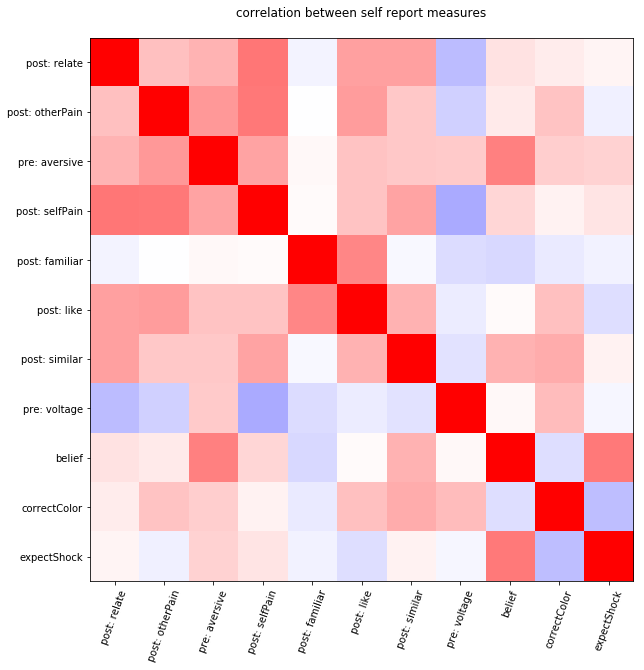

In [19]:
behave.correlation_matrix(self_report)

In [24]:
SCR.index = day2.subjectNames
count = 0
for isubject in range(0, len(SCR)):
    if self_report.index[count] in SCR.index[isubject]: 
        for ikey in self_report.keys():
            SCR.loc[SCR.index[isubject], ikey] =  self_report.loc[self_report.index[count], ikey]
        count = count + 1 
    else: 
        pass

NameError: name 'SCR' is not defined

In [ ]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches([10,10])
ax = plt.imshow(SCR.corr())
title_names = list(SCR.corr().keys())
ax1.set_xticks(np.array(list(range(0,len(title_names)))))
ax1.set_xticklabels(title_names,rotation=70);
ax1.set_yticks(np.array(list(range(0,len(title_names)))))
ax1.set_yticklabels(title_names);
ax.set_cmap('bwr') # 'coolwarm' # 'seismic'
ax.set_clim([-1,1])
ax.set_alpha(1)
plt.title('correlation between self report measures\n');
#plt.colorbar()
plt.show()

In [ ]:
formula = 'renewal ~ prediction + correctColor'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)